## Introduction

This workflow introduces you to an example of an unsupervised land cover classification with Sentinel-2 data. Unsupervised classification means that an algorithm is trained based on unlabelled data and validated with labelled validation data. One method of unsupervised learning is [clustering](https://scikit-learn.org/stable/modules/clustering.html), where a set of objects are grouped together in a group (`cluster`) based on their similarities.

The workflow shows you an example of how to train, classify (predict) and evaluate an unsupervised classfication with the clustering method [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means).


## Machine Learning model

This workflow introduces you to the clustering algorithm [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) provided by the [scikit-learn library](https://scikit-learn.org/stable/).

The `K-means algorithm` clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. The algorithm requires the number of clusters to be specified in beforehand. It scales well to large number of samples and has been used across a large range of application areas in many different fields.


## Data

The workflow classifies a pre-processed Sentinel-2 image subset. The following operations were conducted on the original Sentinel-2 image file:
* `Subsetting` to a dimension of `(200, 600)` pixels
* `Resampling` of all 13 bands to a 10 m resolution, and
* `Saving` the 13 bands as individual `.tif` files

Additionally, a set of validation data points is used to validate the unsupervised classification:
* `validation data`: a .txt file containing 100 labelled training point locations together with the respective land cover class

## Further resources

* [Unsupervised learning - Scikit-learn documentation](https://scikit-learn.org/stable/unsupervised_learning.html)
* [Clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html)
* [K-means clustering - Scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means)

<hr>

## Notebook outline

* [1 - Load and display a Sentinel-2 image](#load_s2_image_3d2)
* [2 - Data transformation for unsupervised classification](#data_transformation_3d2_unsupervised)
* [3 - Unsupervised classification with K-means clustering](#kmeans_clustering_3d2)
* [4 - Assigning clusters to land cover classes](#assign_clusters_3d2)
* [5 - Evaluate the classification performance](#evaluate_3d2)


<hr>

#### Import libraries

In [1]:
import numpy as np

from skimage import io
from skimage import exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from osgeo import gdal

#### Helper function

In [2]:
def composition(band1,band2,band3):
    im_comp=np.dstack([band1/band1.max(), band2/band2.max(), band3/band3.max()])
    for i in range(3):
        v_min, v_max = np.percentile(im_comp[:,:,i],(1,98))
        im_comp[:,:,i] = exposure.rescale_intensity(im_comp[:,:,i],in_range=(v_min,v_max))
    return im_comp

## <a id='load_s2_image_3d2'></a>1. Load and display a Sentinel-2 image

The first step is to inspect a Sentinel-2 image file, in order to better understand the file structure. Sentinel-2 carries a single `Multi-spectral Instrument (MSI)`, which provides 13 bands in the `visible`, `near-infrared` and `shortwave-infrared` spectrum with different ground resolutions:

|#|Name|Spatial Resolution|
|------------|----------------|-----------------|
|B1|Coastal aerosol|60|
|B2|Blue|10|
|B3|Green|10|
|B4|Red|10|
|B5|Red Edge 1|20|
|B6|Red Edge 2|20|
|B7|Red Edge 3|20|
|B8|Near-Infrared|10|
|B8a|Near-Infrared narrow|20|
|B9|Water vapor|60|
|B10|Shortwave-Infrared cirrus|60|
|B11|Shortwave Infrared 1|20|
|B12|Shortwave-Infrared 2|20|

A pre-processed Sentinel-2 image example is available in the folder `./S2_data/`. Originally, Sentinel-2 files are disseminated in the `SAFE` data format. For this example, the image has been preprocessed and each of the 13 band information saved as `.tif` file. Additionally, all bands were resampled to a resolution of 10m.

You can read multiple `tif` files with the function `ImageCollection` from the `io` module of the `skimage` library.

In [ ]:
imFolder = '/content/S2_data/'
coll = io.ImageCollection(imFolder + '*.tif')

# a list of loaded files
print(coll.files)

band_names=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']

['/content/S2_data/B1.tif', '/content/S2_data/B2.tif', '/content/S2_data/B3.tif', '/content/S2_data/B4.tif', '/content/S2_data/B5.tif', '/content/S2_data/B6.tif', '/content/S2_data/B7.tif', '/content/S2_data/B8.tif', '/content/S2_data/B8a.tif', '/content/S2_data/B9.tif', '/content/S2_data/B10.tif', '/content/S2_data/B11.tif', '/content/S2_data/B12.tif']


In a next step, you can apply the helper function `composition` in order to create a `True-Color-composite` of the bands in the visible spectrum: `B2`, `B3` and `B4`. The `composition()` function creates a numpy stack of the three bands and applies the function `rescale_intensity()` of the `exposure` module in order to adjust the composite's intensity levels to the images min and max reflectance values.

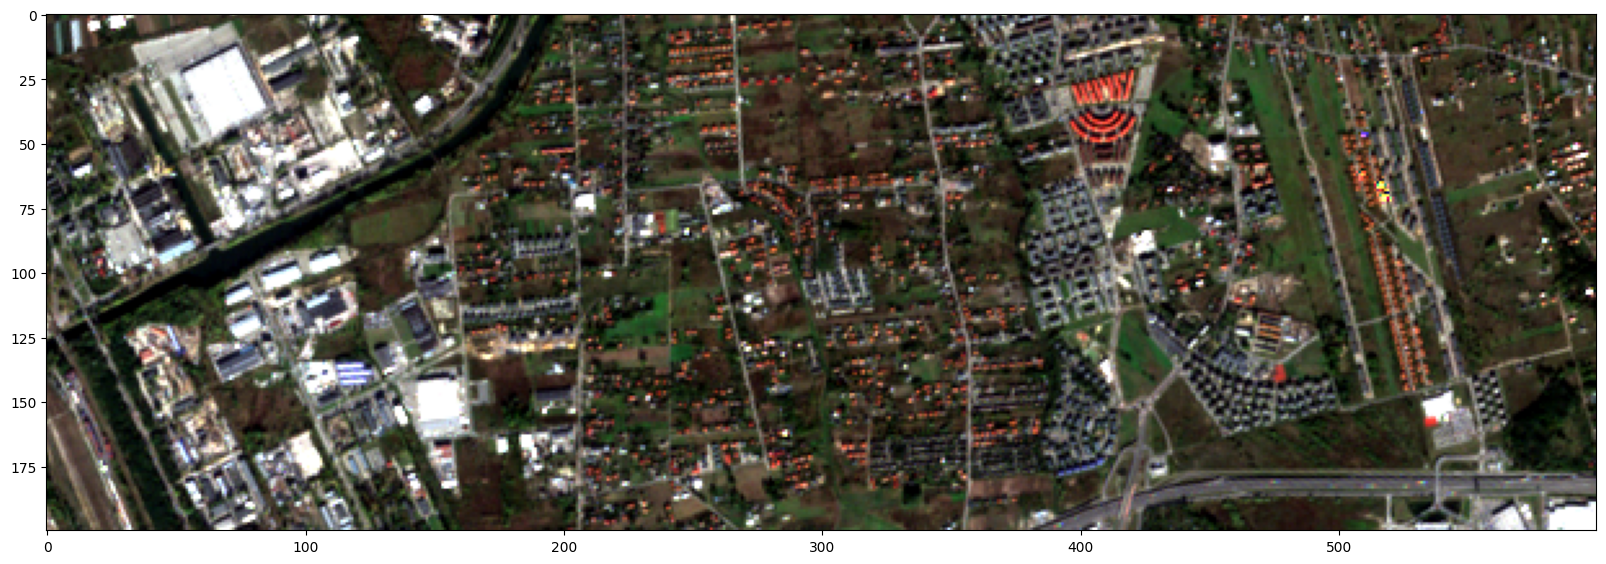

In [ ]:
im_comp = composition(coll[3],coll[2],coll[1])
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

In [ ]:

# Save the array as a TIFF file
io.imsave('true_color_composite.tif', im_comp)


## <a id='data_transformation_3d2_unsupervised'></a>2. Data transformation for unsupervised classification

The next step is to transform the Sentinel-2 image into a format the `K-means` clustering algorithm for unsupervised classifications will understand.

As input data (`X`), we need for each pixel of the Sentinel-2 image the 13 band information. The dimension of the input (`X`) variable shall be an array with the dimension `(120000, 13)`, with rows indicating the number of pixels of the image and the columns containing the reflectance information of each band.

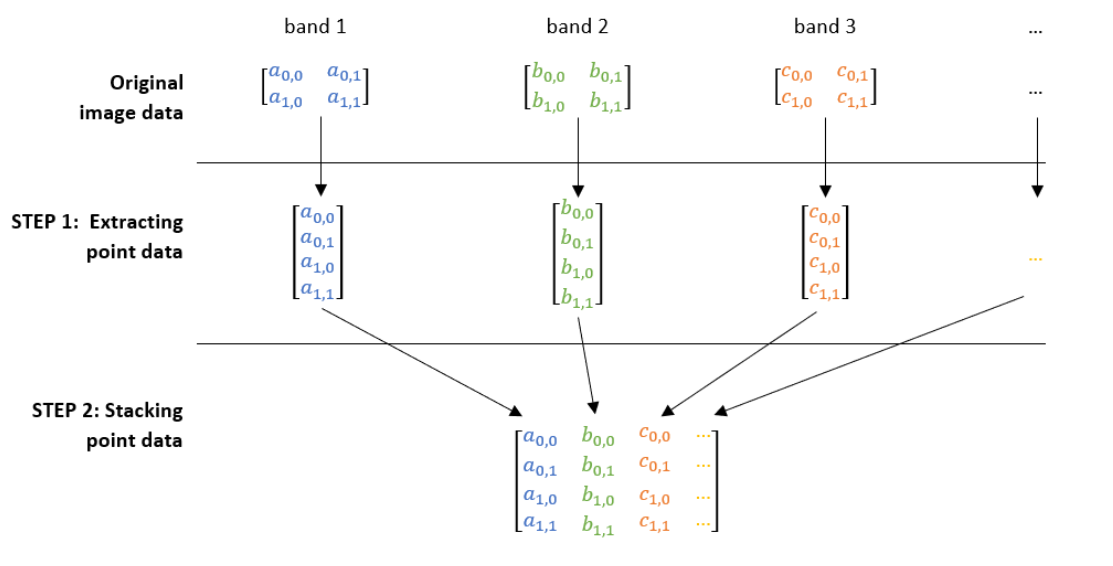

The first step is to loop through each band of the ImageCollection (`coll`), to flatten the array and to append the one-dimensional array to the `bands` list. The result is a list of 13 'flattened' arrays, which need to be transformed into a `numpy.stack`. You can `stack` multiple arrays together into a multi-dimensional array with the function `np.stack()`.
As a last step, we need to `transpose` the stacked array, in order to have the number of pixels (120,000) as rows and number of bands (13) as columns.

(120000, 13)

<br>

## <a id='kmeans_clustering_3d2'></a>3. Unsupervised classification with K-means clustering

The next step is to initiate the `K-means` algorithm and to train (`fit`) the algorithm with the input data (`X`). You can use the `KMeans` class from the scikit-learn library to initiate a k-means clustering process.
The algorithm can be fine-tuned with a set of hyperparameters. We define the following:
* `n_clusters`: the number of clusters that shall be formed. Better results are achieved if a greater number of clusters than desired land cover classes are defined
* `random_state`: determines random number generation for centroid initialization
* `algorithm`: the K-means algorithm type to use, can be 'auto', 'full' or 'elkan'


See the [KMeans class documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) for a full list of keyword arguments.

In [ ]:
kmeans = KMeans(n_clusters=10,
                random_state=2,
                algorithm="lloyd")

<br>

Once the `KMeans` algorithm has been defined, you can apply (`fit`) the algorithm to the input data (`X`). You can use the function `fit_predict()` of the KMeans class in order to build the clusters. The output (`y`) is a numpy array with 120,000 rows containing an integer number from 0 to 9.

(120000,)

<br>

After the clustering, you can visualize the clustering results. For this, you need to reshape the output array (`y`) and bring it into the shape of the original Sentinel-2 image `(200,600)`. You can use the function `reshape()` to do so.


(200, 600)

<br>

Now, you can visualize the `original` and `classified` image next to each other.

Text(0.5, 1.0, 'clustering results')

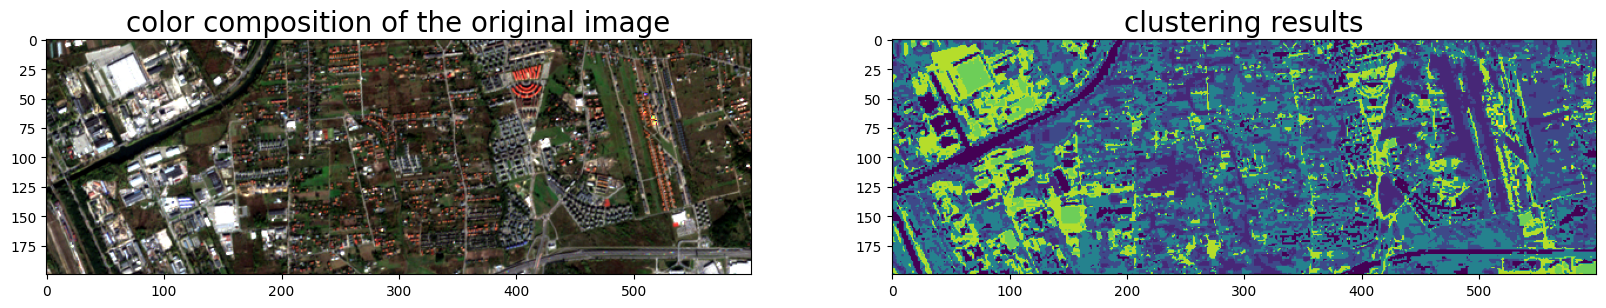

In [ ]:
fig, arr = plt.subplots(1,2,figsize=(20,10))
arr[0].imshow(im_comp)
arr[0].set_title("color composition of the original image",size=20)
arr[1].imshow(y_im)
arr[1].set_title("clustering results",size=20)

<br>

Now, you can also visualize the ten individual clusters.

Text(0.5, 1.0, 'cluster 9')

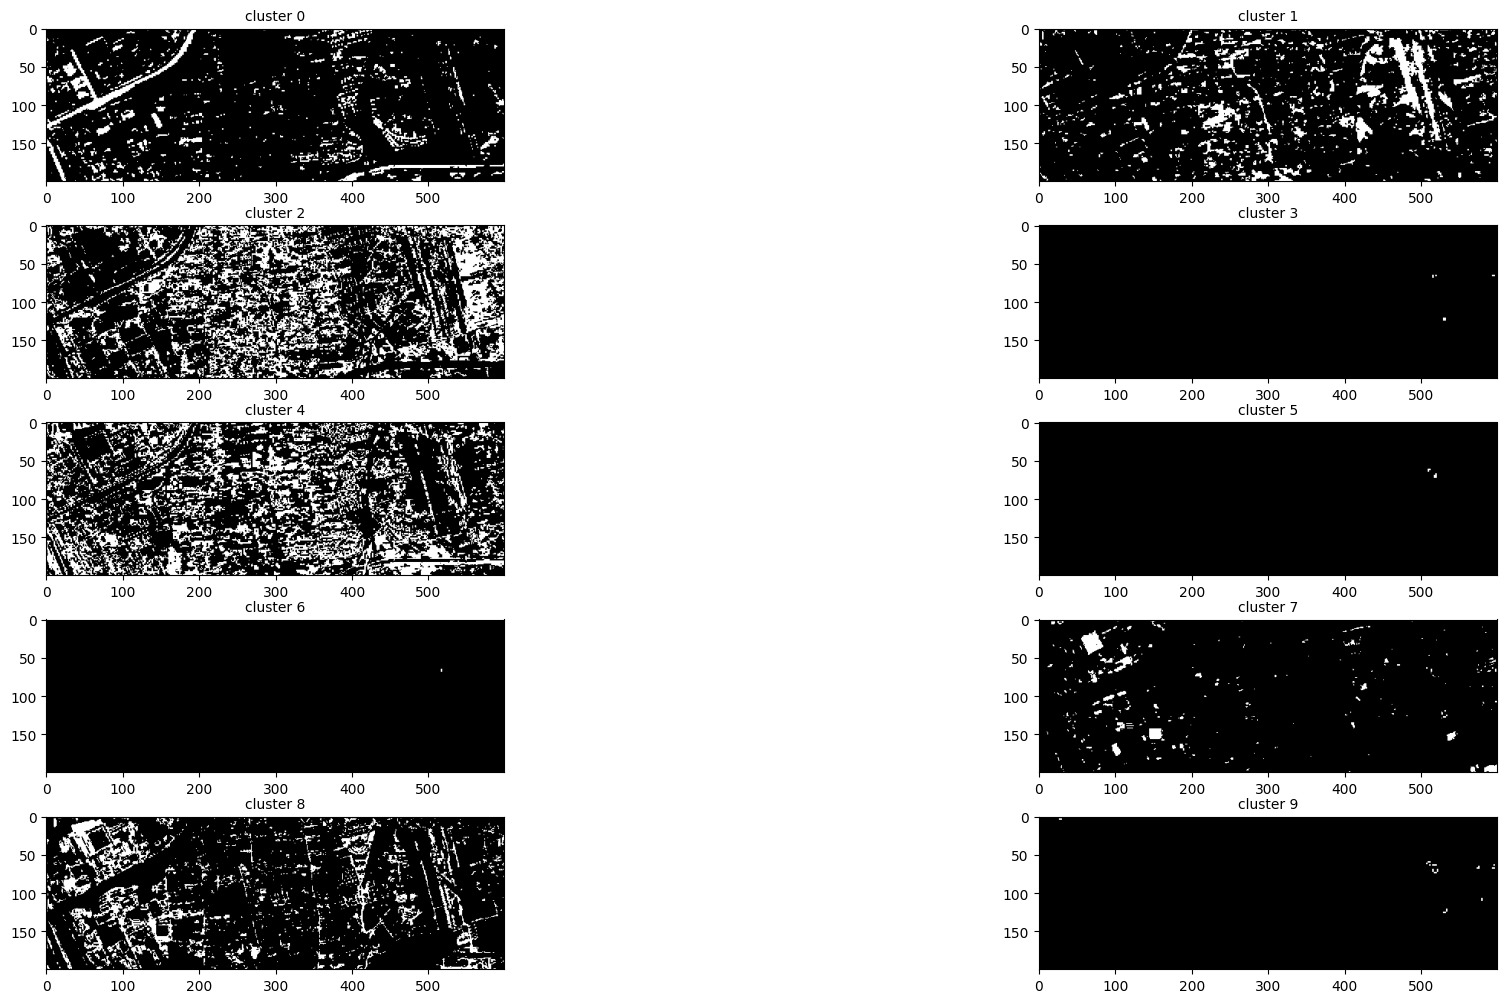

In [ ]:
fig, arr = plt.subplots(5,2,figsize=(20,10))
plt.tight_layout()

arr[0,0].imshow(y_im==0,cmap='gray')
arr[0,0].set_title("cluster 0",size=10)
arr[0,1].imshow(y_im==1,cmap='gray')
arr[0,1].set_title("cluster 1",size=10)
arr[1,0].imshow(y_im==2,cmap='gray')
arr[1,0].set_title("cluster 2",size=10)
arr[1,1].imshow(y_im==3,cmap='gray')
arr[1,1].set_title("cluster 3",size=10)
arr[2,0].imshow(y_im==4,cmap='gray')
arr[2,0].set_title("cluster 4",size=10)
arr[2,1].imshow(y_im==5,cmap='gray')
arr[2,1].set_title("cluster 5",size=10)
arr[3,0].imshow(y_im==6,cmap='gray')
arr[3,0].set_title("cluster 6",size=10)
arr[3,1].imshow(y_im==7,cmap='gray')
arr[3,1].set_title("cluster 7",size=10)
arr[4,0].imshow(y_im==8,cmap='gray')
arr[4,0].set_title("cluster 8",size=10)
arr[4,1].imshow(y_im==9,cmap='gray')
arr[4,1].set_title("cluster 9",size=10)

<br>

## <a id='assign_clusters_3d2'></a>4. Assigning clusters to land cover classes

The next step is to manually assign a cluster to one of the four land cover classes: `1 - Water`, `2 - Artificial surfaces`, `3 - Low vegetation` and `4 - Tree cover`

A visual inspection of the clusters above helps to assign the clusters to the following land cover classes:
* `1 - Water`: cluster 0
* `2 - Artificial surfaces`: clusters 5 ,3 ,8 ,7 ,9 ,6
* `3 - Low vegetation`: clusters 1 ,2
* `4  - Tree cover`: cluster 4

For the assigment, you first have to build a numpy array with the same shape as the classified image. And then you reassign for each pixel the cluster number with the respective number of the land cover class.

<br>

Now, you can visualize the `original` image as well as the `classified` image where each cluster has been assigned a land cover class.

Text(340, 6, 'Tree cover')

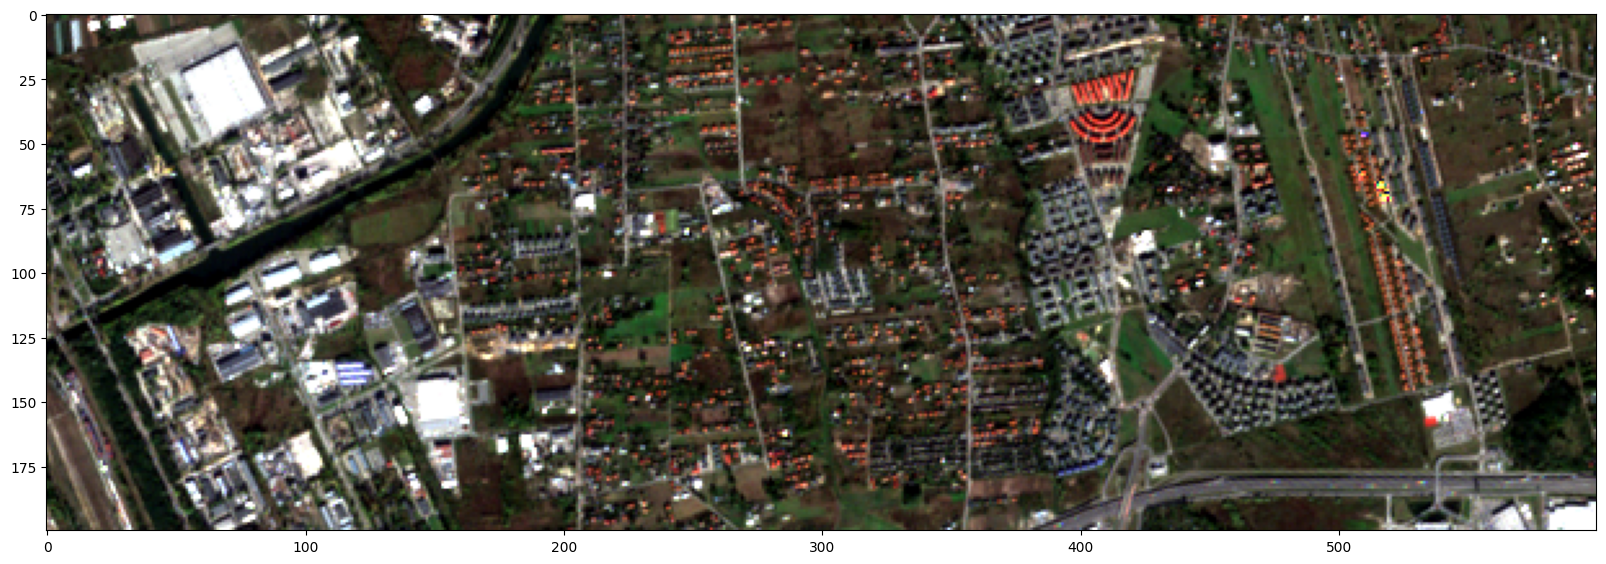

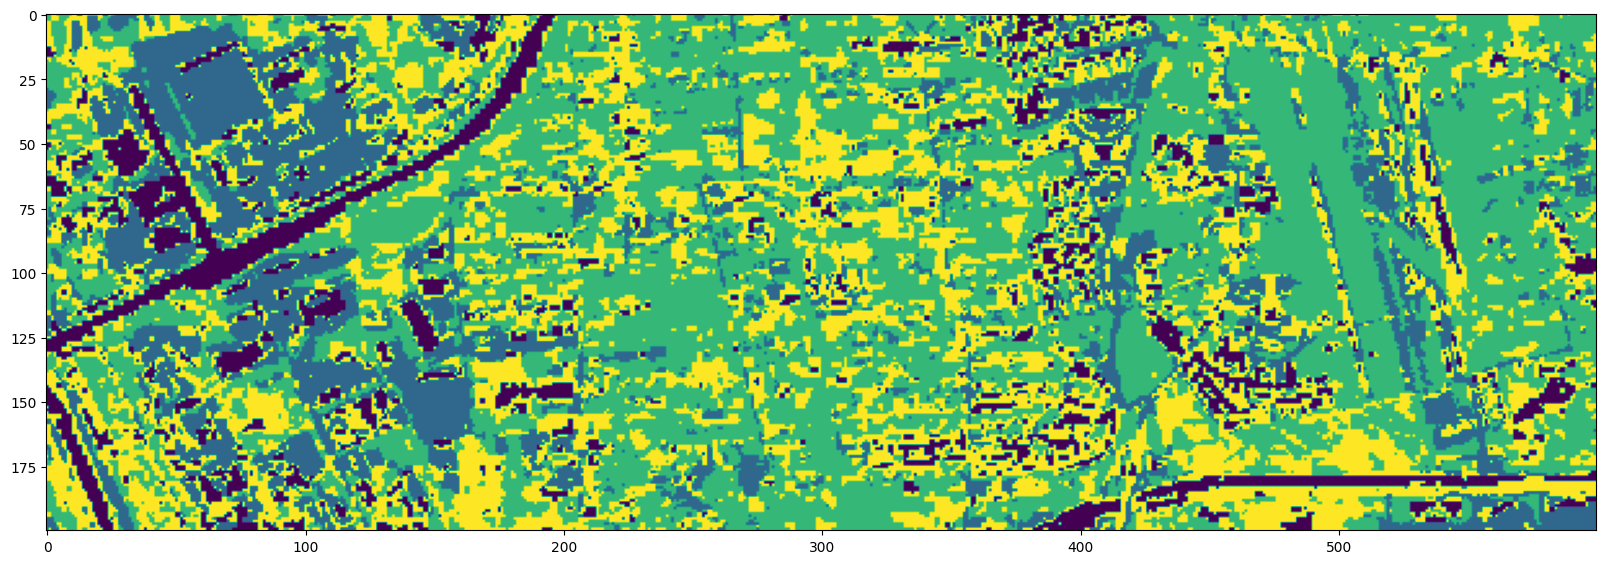

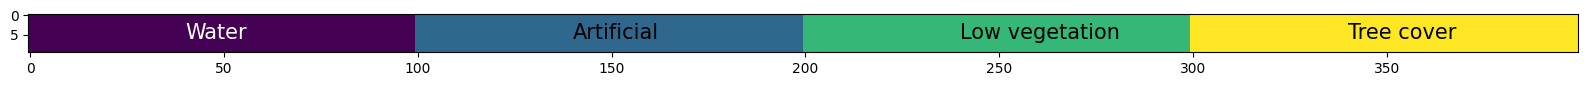

In [ ]:
# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# visualisation of results
plt.figure(figsize=(20,10))
plt.imshow(y_class)

# legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

<br>

## <a id='evaluate_3d2'></a>5. Evaluate the classification performance

The last step is to evaluate the performance of the unsupervised classification in order to better assess the accuracy of the land cover predictions. The evaluation is done with a set of 100 independent `validation` data points, which were manually selected as validation labels.

The first step is to load the 100 validation data points, which are provided in a [.txt file](./validation_data/validation_points.txt) in the folder `./validation_data/`. The validation data consists of 100 rows and three columns:
* `First column`: Y is the horizontal pixel coordinate of the validation point
* `Second column`: X is the vertical pixel coordinate of the validation point
* `Third column`: C is the land cover class index (1 for water, 2 for artificial surfaces, 3 for low vegetation and 4 for tree cover) for the respective validation point

You can load the .txt file with the function `np.loadtxt()`.

In [ ]:
p_val = np.loadtxt('/content/validation_points.txt',dtype='int')
p_val.shape

(100, 3)

<br>

Let us visualize the `validation` points on top of the original Sentinel-2 image. You can see that the validation points are equally distributed across the image.

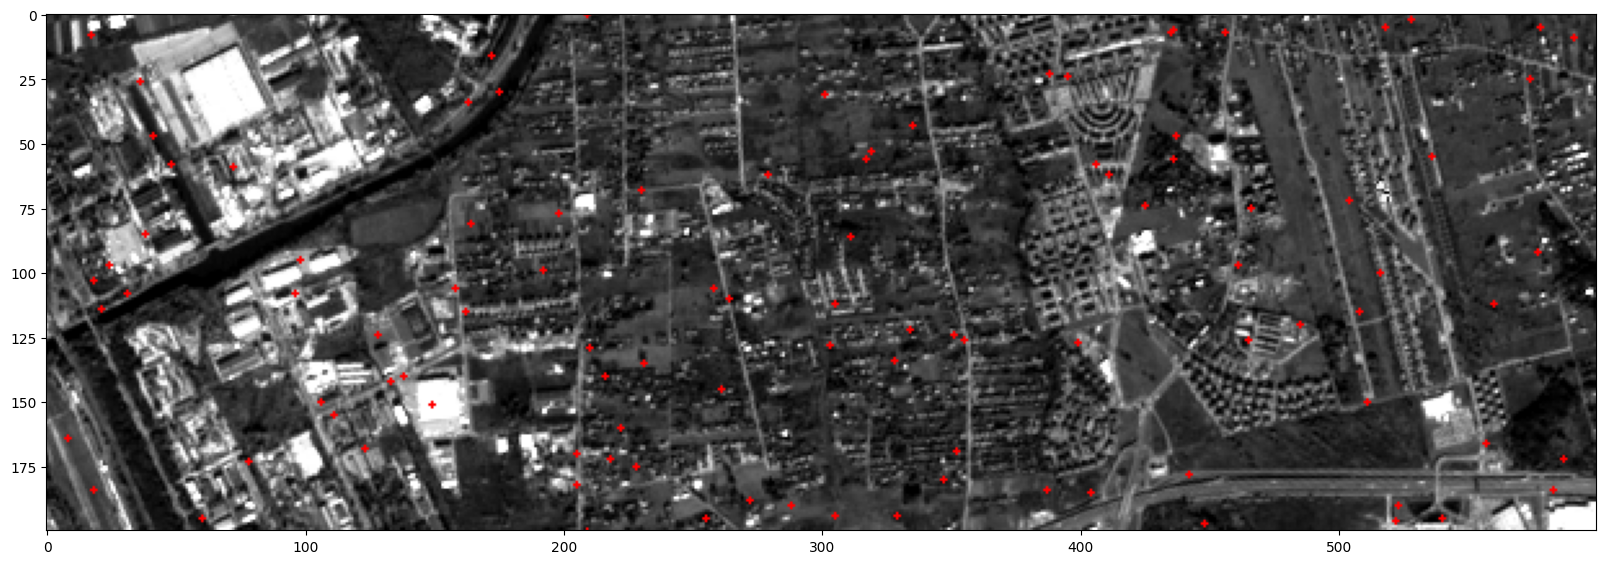

In [ ]:
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in red the validation points
im_comp_p[p_val[:,0],p_val[:,1],0] =1
im_comp_p[p_val[:,0],p_val[:,1],1] =0
im_comp_p[p_val[:,0],p_val[:,1],2] =0

im_comp_p[p_val[:,0]+1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]+1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]+1,p_val[:,1],2] =0

im_comp_p[p_val[:,0]-1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]-1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]-1,p_val[:,1],2] =0

im_comp_p[p_val[:,0],p_val[:,1]+1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]+1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]+1,2] =0

im_comp_p[p_val[:,0],p_val[:,1]-1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]-1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]-1,2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

<br>

Now, with the help of the validation points, we can evaluate the accuracy of the unsupervised classification. Two common metrics to evaluate classifications are `overall accuracy` and `confusion matrix`. With both metrics, you compare for each of the validation point locations the true land cover class with the predicted land cover for the same pixel.

As a first step, for each of the validation points, we need to retrieve the predicted land cover class from the kmeans classification (`y_class`).

In [ ]:
pred_km = y_class[p_val[:,0],p_val[:,1]]
pred_km

array([4., 4., 1., 4., 2., 2., 2., 4., 3., 4., 3., 2., 4., 4., 2., 2., 4.,
       4., 4., 4., 3., 3., 4., 3., 3., 1., 2., 2., 2., 3., 4., 3., 3., 3.,
       3., 3., 4., 3., 2., 1., 4., 3., 3., 1., 1., 1., 3., 4., 1., 3., 2.,
       4., 4., 3., 1., 2., 3., 3., 2., 1., 3., 1., 3., 4., 4., 1., 3., 2.,
       4., 2., 4., 2., 3., 4., 3., 3., 3., 1., 3., 3., 2., 3., 3., 3., 4.,
       3., 3., 2., 3., 3., 3., 2., 3., 3., 3., 4., 2., 2., 3., 4.])

<br>

First, we calculate the [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for the unsupervised classification. You can use the function `accuracy_score()` from scikit-learn's `metrics` module.

In [ ]:
ovAcc_km = accuracy_score(p_val[:,2],pred_km)
print("Overall accuracy for k-means: " + str(100*ovAcc_km) + "%")

Overall accuracy for k-means: 56.99999999999999%


<br>

Another evaluation score is the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). You can calculate the confusion matrix between true and predicted land cover classes with the function `confusion_matrix()` from scikit-learn's `metrics` module. With the function `ConfusionMatrixDisplay()`, you can visualize the confusion matrix for the unsupervised classification.

In [ ]:
confM_km = confusion_matrix(p_val[:,2],pred_km)

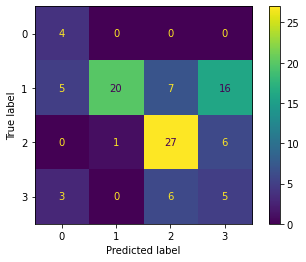

In [ ]:
disp = ConfusionMatrixDisplay(confM_km)
disp.plot()

In [ ]:
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.crs import CRS

# Open one of the original Sentinel-2 bands to retrieve spatial information
with rasterio.open('/content/S2_data/B2.tif') as src:
    profile = src.profile  # Retrieve metadata
    transform = src.transform  # Retrieve transformation information
    #crs = src.crs  # Retrieve CRS information

# Save the true color composite with metadata
profile.update(count=3)  # Update bands count to 3 for RGB composite

# Update or create necessary profile/metadata attributes for the composite
# Assuming im_comp contains the composite data in a numpy array
with rasterio.open('true_color_composite_nou.tif', 'w', **profile) as dst:
    dst.write(im_comp[:, :, 0], 1)  # Write band 1 (B2)
    dst.write(im_comp[:, :, 1], 2)  # Write band 2 (B3)
    dst.write(im_comp[:, :, 2], 3)  # Write band 3 (B4)

    # Update spatial information, CRS, and transformation metadata
    dst.transform = transform
    dst.crs = CRS.from_epsg(3035)

Optional

Supervised classification using Sentinel-2 data

In [ ]:
import numpy as np

from skimage import io
from skimage import exposure
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [ ]:
imFolder = '/content/S2_data/'
coll = io.ImageCollection(imFolder + '*.tif')

# a list of loaded files
print(coll.files)

band_names=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']

In [ ]:
im_comp = composition(coll[3],coll[2],coll[1])
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

In [ ]:
p_water = np.loadtxt('./training_data/water.txt',dtype='int')
p_artificial = np.loadtxt('./training_data/artificial_surfaces.txt',dtype='int')
p_low_veg = np.loadtxt('./training_data/low_vegetation.txt',dtype='int')
p_trees = np.loadtxt('./training_data/tree_cover.txt',dtype='int')

LC_class_names = ['water', 'artificial', 'low vegetation', 'tree cover']

In [ ]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_water[:,0],p_water[:,1]]
    bands.append(band)

In [ ]:
X_water=np.stack(bands).T
X_water.shape

In [ ]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_artificial[:,0],p_artificial[:,1]]
    bands.append(band)

X_artificial=np.stack(bands).T
X_artificial.shape

In [ ]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_low_veg[:,0],p_low_veg[:,1]]
    bands.append(band)

# step 2 - stacking band vectors into a table
X_low_veg=np.stack(bands).T
X_low_veg.shape

In [ ]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_trees[:,0],p_trees[:,1]]
    bands.append(band)

X_trees=np.stack(bands).T
X_trees.shape

In [ ]:
# stacking data for all classes in one table
X=np.vstack((X_water,X_artificial,X_low_veg,X_trees))

X.shape

In [ ]:
y=np.vstack((np.ones((X_water.shape[0], 1)),
             2*np.ones((X_artificial.shape[0], 1)),
             3*np.ones((X_low_veg.shape[0], 1)),
             4*np.ones((X_trees.shape[0], 1))))

y.shape

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth = 10)

dt_clf.fit(X, np.ravel(y))

In [ ]:
fig = plt.figure(figsize=(40,20))
plot_tree(dt_clf,
          feature_names = band_names,
          class_names = LC_class_names )
plt.show()

In [ ]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data).flatten()
    bands.append(band)

X_all=np.stack(bands).T
X_all.shape

In [ ]:
# prediction
Y_pred_dt = dt_clf.predict(X_all)
Y_pred_dt.shape

In [ ]:
Y_im_dt = Y_pred_dt.reshape(coll[1].shape)
Y_im_dt.shape

In [ ]:
# Plot the original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# Plot the classified image
plt.figure(figsize=(20,10))
plt.imshow(Y_im_dt)

# Plot the legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

In [ ]:
p_val = np.loadtxt('./validation_data/validation_points.txt',dtype='int')
p_val.shape

In [ ]:
pred_dt = Y_im_dt[p_val[:,0],p_val[:,1]]

In [ ]:
ovAcc_dt = accuracy_score(p_val[:,2],pred_dt)
print("Overall accuracy for Decision Tree: " + str(100*ovAcc_dt) + "%")

<br>

<br>